# Ataki Dedykowane

Są to ataki, które celują w konkretny algorytm i to w nim szukają słabości. Przykładem ataku dedykowanego jest zastosowanie kryptografii różnicowej na funkcji skrótu MD5. Kryptogrfia różnicowa to zgrabne manipulowanie bitami wiadomości i sprawdzanie jak one się zmnieniają w każdej rundzie algorytmu. Manipulacje te są dopasowywane do zestawu operacji, przesunięć itp. które funkcja wykonuje. Jest to sporo pracy, ale bywa ona opłcalna.

Tym atakiem ostatecznie znaleziono kolizje w MD5, a przykładem takiej kolizji są wiadomości:

In [1]:
import hashlib
a = 0xd131dd02c5e6eec4693d9a0698aff95c2fcab58712467eab4004583eb8fb7f8955ad340609f4b30283e488832571415a085125e8f7cdc99fd91dbdf280373c5bd8823e3156348f5bae6dacd436c919c6dd53e2b487da03fd02396306d248cda0e99f33420f577ee8ce54b67080a80d1ec69821bcb6a8839396f9652b6ff72a70
b = 0xd131dd02c5e6eec4693d9a0698aff95c2fcab50712467eab4004583eb8fb7f8955ad340609f4b30283e4888325f1415a085125e8f7cdc99fd91dbd7280373c5bd8823e3156348f5bae6dacd436c919c6dd53e23487da03fd02396306d248cda0e99f33420f577ee8ce54b67080280d1ec69821bcb6a8839396f965ab6ff72a70
print(hashlib.md5(a.to_bytes((a.bit_length() + 7) // 8, byteorder='big')).hexdigest())
print(hashlib.md5(b.to_bytes((a.bit_length() + 7) // 8, byteorder='big')).hexdigest())

79054025255fb1a26e4bc422aef54eb4
79054025255fb1a26e4bc422aef54eb4


Porównajmy wiadomości [tym narzędziem.](https://text-compare.com/) W roku 2016 znalezienie kolizji w MD5 kosztowało około 0.65$.

In [2]:
a = 0x4dc968ff0ee35c209572d4777b721587d36fa7b21bdc56b74a3dc0783e7b9518afbfa200a8284bf36e8e4b55b35f427593d849676da0d1555d8360fb5f07fea2
b = 0x4dc968ff0ee35c209572d4777b721587d36fa7b21bdc56b74a3dc0783e7b9518afbfa202a8284bf36e8e4b55b35f427593d849676da0d1d55d8360fb5f07fea2
print(hashlib.md5(a.to_bytes((a.bit_length() + 7) // 8, byteorder='big')).hexdigest())
print(hashlib.md5(b.to_bytes((a.bit_length() + 7) // 8, byteorder='big')).hexdigest())

008ee33a9d58b51cfeb425b0959121c9
008ee33a9d58b51cfeb425b0959121c9


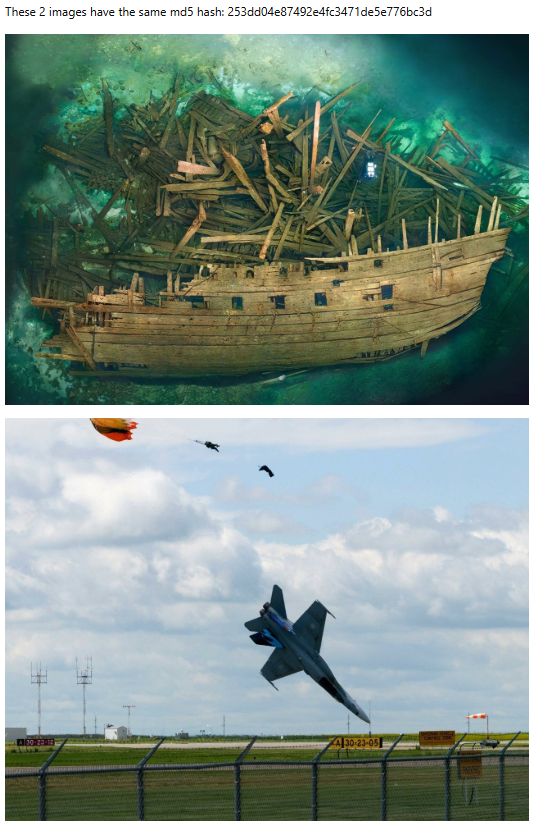

# Ataki Generyczne

Czyli ataki nie na konkretny algorytm, ale na konkretny typ algorytmu - w tym przypadku funkcję skrótu.

## Atak słownikowy
Istnieje kilka rodzajów ataków na funkcje skrótu. Najprostszym sposobem próby złamania hasza jest tzw. atak słownikowy. Polega on na tym, że mamy po prostu duży słownik danych przechowujący pary hasło - skrót. Oczywiście w takiej formie słownik będzie gigantycznym plikiem co czyni ten atak mało skutecznym. Pewnym udoskonaleniem tego ataku jest przechowywanie haseł popularnych, jak np. "admin", "123456", "abc123". Jedynym sposobem zabezpieczenia się przed słabym hasłem jest odpowiednia polityk serwisu, w którym to hasło zakładamy.

In [3]:

# Instalacja Hashcat
# !sudo apt update
# !sudo apt install -y hashcat

In [4]:
# Hasło, które będziemy hashować
password = "princess"

# Wygenerowanie hasha MD5
hash_md5 = hashlib.md5(password.encode()).hexdigest()
print("Hash MD5 dla hasła 'princess':", hash_md5)

Hash MD5 dla hasła 'princess': 8afa847f50a716e64932d995c8e7435a


In [5]:
# Tworzenie pliku z hashem MD5 do złamania
with open("hashes.txt", "w") as f:
    f.write("8afa847f50a716e64932d995c8e7435a")

In [6]:
# Pobranie listy słów rockyou.txt
# !wget https://github.com/brannondorsey/naive-hashcat/releases/download/data/rockyou.txt

In [7]:
# !hashcat -m 0 -a 0 hashes.txt rockyou.txt --force --status  # uruchamiać bez show w razie gdy pusto pod spodem

## Tęczowe tablice
A co jeśli możemy zrobić tak, że pojedynczy wpis hasło - skrót przechowuje tak naprawdę znacznie więcej par? To są właśnie tęczowe tablice. Ogólna idea jest taka, że startujemy od jakiegoś (np. losowego) hasła. Tworzymy z niego skrót, a następnie z tego skrótu tworzymy nowe hasło z wykorzystaniem tzw. funkcji redukcji. No i powtarzamy tę czynność ustaloną liczbę razy, a na końcu do słownika dodajemy parę hasło początkowe - skrót końcowy. Stwórzmy więc krok po kroku własną tęczową tablicę i spróbujmy ją wykorzystać do złamania hasła.

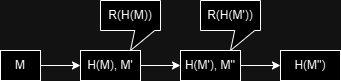

### Krok 1 - stałe

Musimy na początku ustalić kilka rzeczy, które są zależne od mocy obliczeniowej i czasu, którym dysponujemy:
1.  CHAIN_LENGTH - czyli jaka jest długość pojedynczego łancucha haszowań. Ten parametr zadecyduje ile informacji będzie przechowywał pojedynczy wpis, ale wpłynie też na szybkość obliczeń.
2. NUM_CHAINS - czyli ile wpisów będzie przechowywała nasza tęczowa tablica. Tradeoff jest oczywisty.
3. PASSWORD_LENGTH - czyli jakiej długości hasła rozważamy. Parametr ten wpływa także na funkcję redukcji,
4. CHARSET - czyli jakie znaki są w haśle w ogóle dozowlone.

Ponieważ mamy ograniczony czas, proponuję następujący zestaw parametrów:

In [8]:
import string
import numpy as np
CHAIN_LENGTH = 100
NUM_CHAINS = 50
PASSWORD_LENGTH = 4
CHARSET = string.digits

Załóżmy też, że będziemy łamać czterocyfrowe piny.

## Krok 2 - funkcja redukcji

Czyli funkcja, która powinna przyjąć na wejściu skrót, a na wyjściu zwrócić hasło wygenerowane w oparciu o ten skrót. Z oczywistych względów nie ma żadnej "certyfikowanej" funkcji redukcji. Nikomu nie zależy na tym (a przynajmniej nie powinno), aby efektywnie łamać hasze. Mamy tu więc dowolność. Poniżej przedstawiam moją propozycję:

In [9]:
import random
def generate_deterministic_password(index, length=PASSWORD_LENGTH):
    val = str(index)
    if len(val) > length : raise Exception("INDEX TOO BIG")
    while len(val) < length :
        val = "0" + val
    return val

Prosta funkcja, która tworzy ze skrótu liczbę i dodaje do tej liczby pozycję w łańcuchu, a następnie generuje określoną liczbę znaków z wybranego charsetu. Dorzucam jeszcze funkcję generującą hasło:

In [10]:
def reduction_function(hash_str, position, length = PASSWORD_LENGTH) :
    #Moja propozycja: przekonwertuj hash na liczbę, dodaj pozycję w łańcuchu i oblicz modulo 10000
    return generate_deterministic_password(str((int(hash_str, base = 16) + position) % (10**length)), length)

## Krok 3 - generowanie tablicy

No to jesteśmy gotowi. Wygeneurj własną tęczową tablicę wg. opisanego niżej algorytmu:
1. Zainicjalizuj słownik rainbow_table.
2. Wykonuj kroki 3-8 NUM_CHAINS razy.
3. Wygeneruj hasło (wykorzystaj numer iteracji i funkcję generate_deterministic_password). Przypisz do zmiennej start_password.
4. Przypisz do zmiennej current_password wartość ze start_password.
5. Wykonuj kroki 6-7 CHAIN_LENGTH razy.
6. Wygeneruj hash z current_password i przypisz do current_hash.
7. Wygeneruj nowe hasło z wykorzystaniem funkcji redukcji oraz numeru iteracji pętli 5. Wykorzystaj reduction_function. Wynik przypisz do current_password.
8. Dodaj do słownika rainbow_table wartość start_password po kluczem current_hash.
10. Zwróć rainbow_table.

In [11]:
import hashlib

def generate_hash(password, hash_function) :
    return hash_function(password.encode('utf-8')).hexdigest()



def generate_rainbow_table(password_length = PASSWORD_LENGTH, chain_length = CHAIN_LENGTH, num_chains = NUM_CHAINS, hash_function = hashlib.md5, reduction_fn = reduction_function) :
    rainbow_table_dict = {}
    for i in range(num_chains) :
        start_password = generate_deterministic_password(i, password_length)
        current_password = start_password
        for j in range(chain_length) :
            current_hash = generate_hash(current_password, hash_function)
            current_password = reduction_fn(current_hash, j, password_length)
        rainbow_table_dict[current_hash] = start_password
    return rainbow_table_dict

## Krok 4 - łamanie hasza

Mamy już wszystko czego potrzebujemy aby złamać nasz skrót. Zauważ, że każdy z naszych NUM_CHAINS wpisów musimy przeanalizować CHAIN_LENGTH razy. Czyli tak naprawdę to zredukowaliśmy rozmiar wykorzystanej pamięci kosztem wzrostu liczby obliczeń. Algorytm wyszukiwania można przedstawić następująco:

In [12]:
def lookup_in_rainbow_table(target_hash, rainbow_table, password_length = PASSWORD_LENGTH, chain_length = CHAIN_LENGTH, hash_function = hashlib.md5, reduction_fn = reduction_function) :
    for position in range(chain_length - 1, -1, -1) :
        current_hash = target_hash
        for i in range(position, chain_length) :
            current_password = reduction_fn(current_hash, i, password_length)
            current_hash = generate_hash(current_password, hash_function)
            
            if current_hash in rainbow_table:
                start_password = rainbow_table[current_hash]
                current_password = start_password
                for j in range(chain_length) :
                    new_hash = generate_hash(current_password, hash_function)
                    if new_hash == target_hash:
                        return current_password
                    current_password = reduction_fn(generate_hash(current_password, hash_function), j, password_length)
    return None


## Krok 5 - testy

In [13]:
rainbow_table = generate_rainbow_table()
print(rainbow_table)

{'cc8b6a16d74a2462a1be02e79a57fb95': '0000', '1bcef5d8bd566084523bf65b7e1a245d': '0012', 'b7ee0d0d4d5ef995aae0fc691e6d840d': '0029', '0771fc6f0f4b1d7d1bb73bbbe14e0e31': '0037', '44b422a6d1df1d47db5d50a8d0aaca5d': '0005', '5baf1715d2080f65b8517a873afbeb9e': '0034', '8232e119d8f59aa83050a741631803a6': '0044', '839f4c6c1bc77d1cadce615c9bf90b51': '0048', 'bd1354624fbae3b2149878941c60df99': '0010', 'a869dd919b898affa2c1cb86e968ccd4': '0011', '861637a425ef06e6d539aaaff113d1d5': '0013', '4fc848051e4459b8a6afeb210c3664ec': '0014', '642eaa3479d2eb1130f6e0564f00f751': '0015', '6449f44a102fde848669bdd9eb6b76fa': '0016', 'e32084632d369461572832e6582aac36': '0017', '35675fd71a153bf3baab29b904e525c8': '0019', 'b9b72b29352f3764ea4dec130772bd9d': '0020', '409bbd0d0f516a326f2080c26a10d530': '0021', '2b296ab4f2db709cc20056f93c4b04ee': '0022', 'e85cc63b4f0f312f11e073fc68ccffd5': '0023', 'fac7fead96dafceaf80c1daffeae82a4': '0036', 'e38e37a99f7de1f45d169efcdb288dd1': '0025', '6d4f95bf53bba28f148641c8561dbf

In [14]:
hash = hashlib.md5("9999".encode('utf-8')).hexdigest()
print(hash)
print()
result = lookup_in_rainbow_table(hash, rainbow_table)
print(result)
result_hash = hashlib.md5(result.encode('utf-8')).hexdigest()
print(result_hash)

assert hash == result_hash
print("Success")

fa246d0262c3925617b0c72bb20eeb1d

9999
fa246d0262c3925617b0c72bb20eeb1d
Success


Zwórć uwagę, że w miarę regularnie łamiemy 4 cyfrowy kod pin posiadając raptem 50 wpisów w naszym słowniku (!!!). A teraz wyobraź sobie, że w internecie są dostępne takie tablice o rozmiarach terabajtów. Dodaj do tego fakt, że po pierwsze potencjalny atakujący nie chce złamać konkretnie Twojego pinu. Atakującemu wystarczy po prostu złamanie jak największej liczby pinów.


Ok, czas na eksperymenty. Pobawmy się tym co mamy.

## Zadania

1. Napisz funkcję iterującą po wszystkich pinach od 0000 do 9999 i policz ile z nich udało Ci się złamać tęczową tablicą.
2. Wymyśl własną funkcję redukcji i ponownie wykonaj 1. Czy Twoja funkcja redukcji jest bardziej efektywna?
3. Spróbuj zwiększyć długość pinu i dostosować parametry tablicy.
4. Skorzystaj z certyfikowanych funkcji skrótu. Sprawdź, czy uda Ci się osiągnąć to samo.


In [15]:
def broke_password(i, rainbow_table, printing = False, chain_length = CHAIN_LENGTH, password_length = PASSWORD_LENGTH, hash_function = hashlib.md5, reduction_fn = reduction_function) :
    password = generate_deterministic_password(i, password_length)
    hash = hash_function(password.encode('utf-8')).hexdigest()
    result = lookup_in_rainbow_table(hash, rainbow_table, password_length, chain_length = chain_length, hash_function = hash_function, reduction_fn = reduction_fn)
    if result is not None :
        result_hash = hash_function(result.encode('utf-8')).hexdigest()
        if hash == result_hash :
            if printing :
                print("Password", password, "broken.", 10**password_length - i - 1, "left")
            return password, result_hash
    return None

In [16]:
# Funkcja broke_all_pins z zarządzaniem GPU
def broke_all_pins(rainbow_table, reduction_fn=reduction_function, password_length=PASSWORD_LENGTH, chain_length=CHAIN_LENGTH, printing=False, hash_function=hashlib.md5):
    # Przetwarzanie wszystkich pinów z zarządzaniem GPU
    broken = {}
    max_pin = 10 ** password_length

    for i in range(max_pin):
        result = broke_password(
            i,
            rainbow_table=rainbow_table,
            printing=printing,
            chain_length=chain_length,
            password_length=password_length,
            hash_function=hash_function,
            reduction_fn=reduction_fn
        )
        if result is not None:
            if result[0] is not None:
                broken[result[0]] = result[1]

    return broken

In [17]:
# Ta funkcja jest tu dlatego, że działa dokładniej niż Pythonowy round i do tego w podobnym czasie
def round_number(x, n):
    factor = 10 ** n
    return (int(x * factor + 0.5)) / factor

In [18]:
from time import time

def time_test(reduction_fn = reduction_function, password_length = PASSWORD_LENGTH, chain_length = CHAIN_LENGTH, printing = True, hash_function = hashlib.md5, num_chains = NUM_CHAINS) :
    
    rainbow_table = generate_rainbow_table(password_length = password_length, chain_length = chain_length, num_chains = num_chains, hash_function = hash_function, reduction_fn = reduction_fn)
    
    t1 = time()
    result = broke_all_pins(rainbow_table = rainbow_table, reduction_fn = reduction_fn, password_length = password_length, printing = printing, chain_length = chain_length, hash_function = hash_function)
    t2 = time()

    elapsed_time = t2 - t1
    print(f"{len(result)} Passwords broken in time of {elapsed_time} seconds using function {reduction_fn.__name__}. That is {round_number(100 * len(result) / (10**password_length), 2)} % of all passwords")
    print(result)
    return elapsed_time

In [19]:
def custom_reduction_function(hash_str, position, length = PASSWORD_LENGTH) :
    return generate_deterministic_password((int(hash_str[:length], base=16) + position) % (10**length), length)

In [20]:
first_time = time_test()

Password 0000 broken. 9999 left
Password 0001 broken. 9998 left
Password 0005 broken. 9994 left
Password 0007 broken. 9992 left
Password 0008 broken. 9991 left
Password 0010 broken. 9989 left
Password 0011 broken. 9988 left
Password 0012 broken. 9987 left
Password 0013 broken. 9986 left
Password 0014 broken. 9985 left
Password 0015 broken. 9984 left
Password 0016 broken. 9983 left
Password 0017 broken. 9982 left
Password 0018 broken. 9981 left
Password 0019 broken. 9980 left
Password 0020 broken. 9979 left
Password 0021 broken. 9978 left
Password 0022 broken. 9977 left
Password 0023 broken. 9976 left
Password 0024 broken. 9975 left
Password 0025 broken. 9974 left
Password 0026 broken. 9973 left
Password 0027 broken. 9972 left
Password 0029 broken. 9970 left
Password 0031 broken. 9968 left
Password 0032 broken. 9967 left
Password 0033 broken. 9966 left
Password 0034 broken. 9965 left
Password 0035 broken. 9964 left
Password 0036 broken. 9963 left
Password 0037 broken. 9962 left
Password

In [21]:
second_time = time_test(custom_reduction_function)

Password 0000 broken. 9999 left
Password 0001 broken. 9998 left
Password 0003 broken. 9996 left
Password 0004 broken. 9995 left
Password 0006 broken. 9993 left
Password 0007 broken. 9992 left
Password 0008 broken. 9991 left
Password 0009 broken. 9990 left
Password 0010 broken. 9989 left
Password 0011 broken. 9988 left
Password 0013 broken. 9986 left
Password 0014 broken. 9985 left
Password 0015 broken. 9984 left
Password 0016 broken. 9983 left
Password 0017 broken. 9982 left
Password 0018 broken. 9981 left
Password 0020 broken. 9979 left
Password 0021 broken. 9978 left
Password 0022 broken. 9977 left
Password 0023 broken. 9976 left
Password 0027 broken. 9972 left
Password 0028 broken. 9971 left
Password 0029 broken. 9970 left
Password 0030 broken. 9969 left
Password 0032 broken. 9967 left
Password 0033 broken. 9966 left
Password 0034 broken. 9965 left
Password 0035 broken. 9964 left
Password 0036 broken. 9963 left
Password 0037 broken. 9962 left
Password 0038 broken. 9961 left
Password

Założenie, że przekazywanie krótszego hasha do funkcji generującej hasło sprawi, że całość będzie lepiej zoptymalizowana, jednak nie wprowadziło to Różnicy tak dużej jak można się było spodziewać w przypadku tak zauważajnej różnicy długości hasha. może to wskazywać na to, że optymalizacja metody int(str, base = 16) jest wyjątkowo dobrze zooptymalizowana w Pythonie. sprawia to także, że całość jest mniej bezpieczna, ponieważ łamiemy o 100 haseł więcej niż w przypadku poprzedniej funkcji redukcji

In [22]:
CHAIN_LENGTH = 200
NUM_CHAINS = 100
PASSWORD_LENGTH = 5
CHARSET = string.digits
# def time_test(reduction_fn = reduction_function, password_length = PASSWORD_LENGTH, chain_length = CHAIN_LENGTH, printing = True, hash_function = hashlib.md5, num_chains = NUM_CHAINS) :
third_time = time_test(reduction_fn = reduction_function if first_time <= second_time else custom_reduction_function, password_length = PASSWORD_LENGTH, chain_length = CHAIN_LENGTH, num_chains = NUM_CHAINS)

Password 00000 broken. 99999 left
Password 00001 broken. 99998 left
Password 00002 broken. 99997 left
Password 00003 broken. 99996 left
Password 00004 broken. 99995 left
Password 00005 broken. 99994 left
Password 00006 broken. 99993 left
Password 00007 broken. 99992 left
Password 00008 broken. 99991 left
Password 00010 broken. 99989 left
Password 00011 broken. 99988 left
Password 00012 broken. 99987 left
Password 00013 broken. 99986 left
Password 00014 broken. 99985 left
Password 00015 broken. 99984 left
Password 00017 broken. 99982 left
Password 00018 broken. 99981 left
Password 00019 broken. 99980 left
Password 00020 broken. 99979 left
Password 00021 broken. 99978 left
Password 00022 broken. 99977 left
Password 00024 broken. 99975 left
Password 00025 broken. 99974 left
Password 00027 broken. 99972 left
Password 00028 broken. 99971 left
Password 00029 broken. 99970 left
Password 00030 broken. 99969 left
Password 00031 broken. 99968 left
Password 00034 broken. 99965 left
Password 00035

Zwiększenie długości napisu o n miejsc zwiększa czas łamania haseł 10^n razy. O tyle, o ile samo customizowanie funkcji działa prosto, zwłaszcza po wprowadzonych modyfikacjach, to łamanie wszystkich haseł zajmuje naprawdę sporą ilość czasu (dla pinów 6 znakowych wyszło mi około 5000 minut, co daje około 3.5 dnia łamania. bez GPU jest to więc nieopłacalne, ergo im dłuższe hasło tym lepsze). Dodatkowo, udało się złamać jedynie 16% haseł, co jest 50% poprawą względem poprzedniej opcji. Bezpieczeństwo zdecydowanie wzrosło

In [23]:
CHAIN_LENGTH = 100
NUM_CHAINS = 50
PASSWORD_LENGTH = 4
CHARSET = string.digits
# reduction_function if first_time <= second_time else
third_time = time_test(reduction_fn =  custom_reduction_function, password_length = PASSWORD_LENGTH, chain_length = CHAIN_LENGTH, num_chains = NUM_CHAINS, hash_function = hashlib.sha512)

Password 0000 broken. 9999 left
Password 0001 broken. 9998 left
Password 0002 broken. 9997 left
Password 0003 broken. 9996 left
Password 0004 broken. 9995 left
Password 0006 broken. 9993 left
Password 0007 broken. 9992 left
Password 0009 broken. 9990 left
Password 0010 broken. 9989 left
Password 0011 broken. 9988 left
Password 0012 broken. 9987 left
Password 0013 broken. 9986 left
Password 0014 broken. 9985 left
Password 0017 broken. 9982 left
Password 0018 broken. 9981 left
Password 0019 broken. 9980 left
Password 0020 broken. 9979 left
Password 0021 broken. 9978 left
Password 0022 broken. 9977 left
Password 0023 broken. 9976 left
Password 0024 broken. 9975 left
Password 0025 broken. 9974 left
Password 0026 broken. 9973 left
Password 0027 broken. 9972 left
Password 0028 broken. 9971 left
Password 0029 broken. 9970 left
Password 0030 broken. 9969 left
Password 0031 broken. 9968 left
Password 0033 broken. 9966 left
Password 0034 broken. 9965 left
Password 0035 broken. 9964 left
Password

Zmiana funkcji hashującej ma wpływ praktycznie jedynie na formę i długość hasha. Dla dłuższych hashy wydajniejsza okazała funkcja custom_reduction_function, ponieważ skraca ona długość hasha na którym wykonujemy operacje, co prowadzi do skrócenia casu łamania haseł. Bezpieczeństwo pozostaje cały czas na poziomie 30%